## Preparation

In [29]:
import sys
import numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [30]:
# NLTK Stop words
import nltk
# first time: nltk.download('stopwords')
# if you already have the stopwords, run the one blow
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

## 20 Newsgroup Dataset

In [31]:
# Import Dataset
from sklearn.datasets import fetch_20newsgroups
newsgroups_test = fetch_20newsgroups(subset='test')
pprint(list(newsgroups_test.target_names))
pprint(newsgroups_test.filenames.shape)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
(7532,)


In [42]:
categories = ['rec.sport.baseball', 'soc.religion.christian', 'sci.med', 'rec.autos']
newsgroups = fetch_20newsgroups(subset='test', categories = categories)

data = newsgroups.data
len(data)
pprint(data[:1])

['From: andrea@unity.ncsu.edu (Andrea M Free-Kwiatkowski)\n'
 'Subject: Re: Can men get yeast infections?\n'
 'Organization: NCSU\n'
 'X-Newsreader: TIN [version 1.1 PL8]\n'
 'Distribution: na\n'
 'Lines: 21\n'
 '\n'
 'Steve Pope (spp@zabriskie.berkeley.edu) wrote:\n'
 ': A woman once told me her doctor told her that I\n'
 ': could catch, asymptomatically, her yeast infection\n'
 ': from her, then give it back to her, causing\n'
 ': a relapse.\n'
 '\n'
 ": Probably bogus, but if not, it's another reason to use\n"
 ': latex...\n'
 '\n'
 ': Steve\n'
 '\n'
 "It isn't bogus.  I had chronic vaginal yeast infections that would go away\n"
 'with cream but reappear in about 2 weeks.  I had been on 3 rounds of\n'
 'antibiotics for a resistant sinus infection and my husband had been on\n'
 'amoxicillin also for a sinus infection.  After six months of this, I went\n'
 'to a gynecologist who had me culture my husband seminal fluid.  After 7\n'
 'days incubation he had quite a bit of yeast growth (

## Data Preprocessing

In [43]:
data_words = list(map(gensim.utils.simple_preprocess, data))
print(data_words[:1])

[['from', 'andrea', 'unity', 'ncsu', 'edu', 'andrea', 'free', 'kwiatkowski', 'subject', 're', 'can', 'men', 'get', 'yeast', 'infections', 'organization', 'ncsu', 'newsreader', 'tin', 'version', 'pl', 'distribution', 'na', 'lines', 'steve', 'pope', 'spp', 'zabriskie', 'berkeley', 'edu', 'wrote', 'woman', 'once', 'told', 'me', 'her', 'doctor', 'told', 'her', 'that', 'could', 'catch', 'her', 'yeast', 'infection', 'from', 'her', 'then', 'give', 'it', 'back', 'to', 'her', 'causing', 'relapse', 'probably', 'bogus', 'but', 'if', 'not', 'it', 'another', 'reason', 'to', 'use', 'latex', 'steve', 'it', 'isn', 'bogus', 'had', 'chronic', 'vaginal', 'yeast', 'infections', 'that', 'would', 'go', 'away', 'with', 'cream', 'but', 'reappear', 'in', 'about', 'weeks', 'had', 'been', 'on', 'rounds', 'of', 'antibiotics', 'for', 'resistant', 'sinus', 'infection', 'and', 'my', 'husband', 'had', 'been', 'on', 'amoxicillin', 'also', 'for', 'sinus', 'infection', 'after', 'six', 'months', 'of', 'this', 'went', 'to

### Cleaning, Form the bigram and trigram, and Lemmatization

In [44]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
pprint(lda_model.print_topics())

[(0,
  '0.010*"doctor" + 0.007*"treatment" + 0.007*"study" + 0.007*"eat" + '
  '0.007*"silicon" + 0.007*"medical" + 0.006*"diet" + 0.005*"infection" + '
  '0.005*"food" + 0.004*"disease"'),
 (1,
  '0.009*"god" + 0.007*"word" + 0.007*"write" + 0.006*"people" + 0.006*"paul" '
  '+ 0.006*"sin" + 0.005*"give" + 0.005*"vote" + 0.005*"christian" + '
  '0.005*"man"'),
 (2,
  '0.016*"organization" + 0.015*"car" + 0.014*"com" + 0.010*"write" + '
  '0.009*"university" + 0.006*"engine" + 0.005*"buy" + 0.005*"article_apr" + '
  '0.005*"article" + 0.005*"hear"'),
 (3,
  '0.013*"com" + 0.012*"year" + 0.011*"organization" + 0.011*"game" + '
  '0.011*"write" + 0.008*"time" + 0.008*"player" + 0.005*"university" + '
  '0.005*"first" + 0.005*"guy"')]


In [46]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5214,"doctor, treatment, study, eat, silicon, medica...","[andrea, unity, ncsu, andrea, free, kwiatkowsk..."
1,1,2.0,0.3213,"organization, car, com, write, university, eng...","[com, leon_traister, vitamin, dose, organizati..."
2,2,2.0,0.6186,"organization, car, com, write, university, eng...","[eliot, eliot, review, audi, organization, sku..."
3,3,1.0,0.7750,"god, word, write, people, paul, sin, give, vot...","[atterlep, cardinal, ximenez, organization, na..."
4,4,3.0,0.3409,"com, year, organization, game, write, time, pl...","[deitch, gisatl, deitch, baseball, spanish, or..."
5,5,0.0,0.5138,"doctor, treatment, study, eat, silicon, medica...","[canrem, com, new, method, diagnose, discover,..."
6,6,1.0,0.9836,"god, word, write, people, paul, sin, give, vot...","[hate, sin, organization, interesting, point, ..."
7,7,3.0,0.6448,"com, year, organization, game, write, time, pl...","[lws, eembox, ncku, tw, wenhsiang, lin, stat, ..."
8,8,2.0,0.4587,"organization, car, com, write, university, eng...","[scheiber, sage_cc_purdue, jennifer, scheiber,..."
9,9,3.0,0.8918,"com, year, organization, game, write, time, pl...","[drm_tesla_njit, time, player, organization, n..."


/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


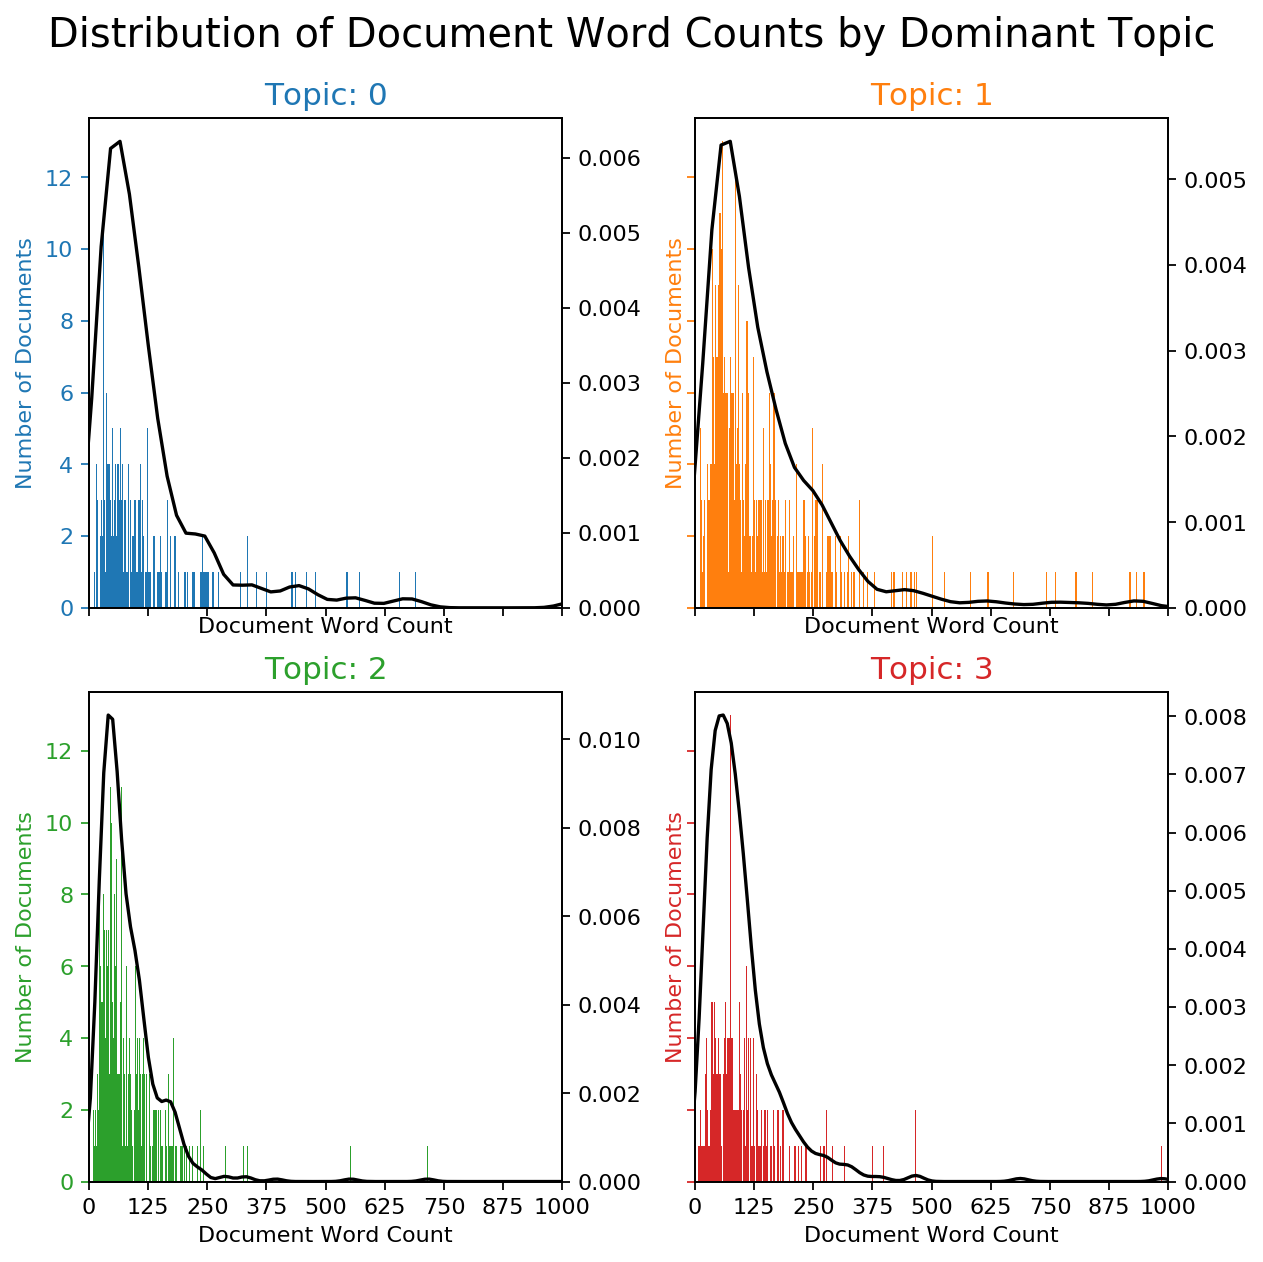

In [47]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(8,8), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=14, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=18)
plt.show()

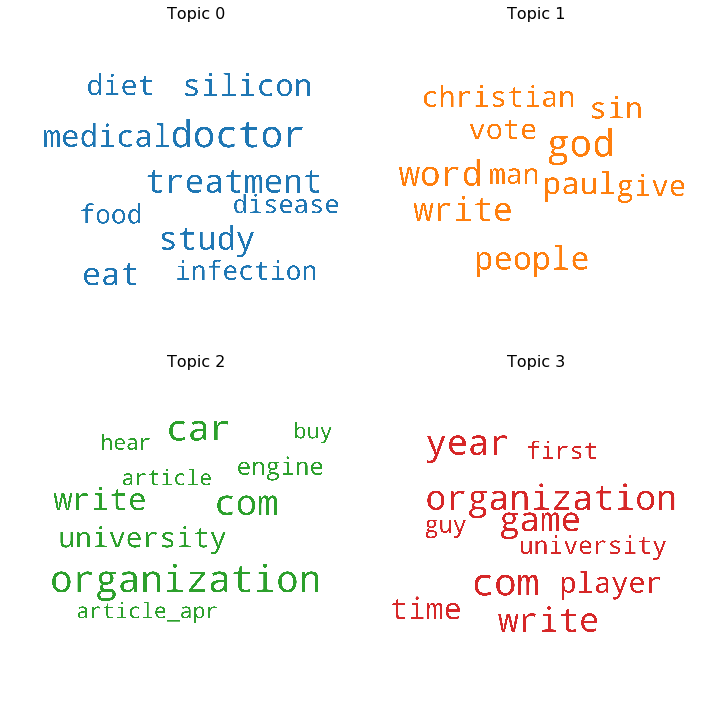

In [48]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [49]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      41.106525        1       1 -0.156416  0.207202
3      26.103575        1       2 -0.101641 -0.104975
2      19.947348        1       3 -0.030438 -0.160635
0      12.842558        1       4  0.288495  0.058408, topic_info=      Category         Freq             Term        Total  loglift  logprob
term                                                                       
142    Default   567.000000              car   567.000000  30.0000  30.0000
633    Default   542.000000             game   542.000000  29.0000  29.0000
54     Default  1430.000000              com  1430.000000  28.0000  28.0000
1052   Default   704.000000              god   704.000000  27.0000  27.0000
31     Default  1521.000000     organization  1521.000000  26.0000  26.0000
936    Default   590.000000             word   590.000000  25.0000  25.0000
15     Default   248.000000           doctor   248.000000  24.0000  24.0000
992    Default   380.000000           player   380.000000  23.0000  23.0000
678    Default   771.000000             year   771.000000  22.0000  22.0000
77     Default   711.000000             time   711.000000  21.0000  21.0000
1087   Default   464.000000             paul   464.000000  20.0000  20.0000
882    Default   237.000000            study   237.000000  19.0000  19.0000
200    Default   240.000000           engine   240.000000  18.0000  18.0000
593    Default   438.000000              sin   438.000000  17.0000  17.0000
598    Default   716.000000       university   716.000000  16.0000  16.0000
896    Default   184.000000        treatment   184.000000  15.0000  15.0000
47     Default  1473.000000            write  1473.000000  14.0000  14.0000
3658   Default   192.000000              eat   192.000000  13.0000  13.0000
1776   Default   398.000000        christian   398.000000  12.0000  12.0000
7824   Default   401.000000             vote   401.000000  11.0000  11.0000
27     Default   386.000000              man   386.000000  10.0000  10.0000
5653   Default   168.000000          silicon   168.000000   9.0000   9.0000
815    Default   161.000000          medical   161.000000   8.0000   8.0000
1606   Default   248.000000              guy   248.000000   7.0000   7.0000
606    Default   237.000000         baseball   237.000000   6.0000   6.0000
571    Default   359.000000            faith   359.000000   5.0000   5.0000
1706   Default   188.000000              buy   188.000000   4.0000   4.0000
3570   Default   142.000000             diet   142.000000   3.0000   3.0000
1466   Default   303.000000      article_apr   303.000000   2.0000   2.0000
23     Default   118.000000        infection   118.000000   1.0000   1.0000
...        ...          ...              ...          ...      ...      ...
692     Topic4    84.382263              aid    85.257164   2.0421  -5.6778
967     Topic4    64.644798  kenneth_gilbert    65.402214   2.0408  -5.9442
775     Topic4    62.654079           health    63.390045   2.0407  -5.9755
712     Topic4    64.356110             cell    65.122200   2.0406  -5.9487
6322    Topic4    65.448547          calcium    66.236832   2.0404  -5.9319
714     Topic4    55.797432         chemical    56.537663   2.0392  -6.0914
11603   Topic4    55.785389              cph    56.553776   2.0387  -6.0916
3446    Topic4    51.949215          candida    52.672443   2.0386  -6.1628
10260   Topic4    55.991508          thyroid    56.796623   2.0381  -6.0879
2450    Topic4    53.049252        professor    53.813957   2.0381  -6.1419
3616    Topic4    49.858700        nutrition    50.580505   2.0380  -6.2039
861     Topic4    57.460751             risk    58.302525   2.0379  -6.0620
9       Topic4    49.210926          chronic    49.934547   2.0378  -6.2170
3500    Topic4   101.028976           tablet   102.835838   2.0347  -5.4977
5653    Topic4   163.812714          silicon   168.573181   2